# Processing ZEN data with Aurora

This is an example of how to process ZEN data with Aurora.  For now this is an example of how to process data in the field to get a first-order estimate of what the MT response looks like. 

The order will be:

1. Connect laptop to ZEN and put in SD mode
2. Copy only the files for the desired station
3. Create an MTH5 from the data
4. Processes the a 256 run and a 4096 run
5. Plot results

In [1]:
%matplotlib widget

In [2]:
from pathlib import Path

from mth5 import read_file
from mth5.io.zen import Z3DCollection, zen_tools
from mth5.mth5 import MTH5
from mtpy import MT

2023-04-24 17:10:36,870 [line 141] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log
2023-04-24 17:10:37,645 [line 113] matplotlib.get_mtpy_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mtpy\logs\matplotlib_warn.log


## Important Parameters

Set some important parameters up from so you don't have to search through the notebook.

In [3]:
station = "KAT001"
save_path = Path(r"c:\Users\jpeacock\OneDrive - DOI\MTData\Katmai2021")
mth5_path = save_path.joinpath(station, f"{station}_with_1s_run.h5")
combine = True

## 1. Download data

Connect the laptop to the ZEN and put into SD mode through ZENACQ.  This will load the SD cards as individual drives from which we can get the data from.

### Check the drives are mounted

You can use a Windows 'File Explorer' to see if the drives are mounted or you can use:

<div class="alert alert-block alert-info">
<b>NOTE:</b> This assumes that the SD cards have been renamed with `*CH#`, so `ZEN24_CH1`.  If they have not been suggest naming them as such to keep track of which SD card is in which channel.  They should be named this way by default coming from Zonge. 
</div>

In [4]:
zen_tools.get_drive_names()

### Copy files

To copy files over you need to know the station name that you want to download, for newer firmware this is just a number, for older you can add a string in front.  `423` or `mb423`.  

If you like to keep your data on the SD cards for the survey then adding the start date will skip any previously recorded data, this give you some peace of mind that there are redundant locations the data are stored.  

<div class="alert alert-block alert-info">
<b>NOTE:</b> The `copy_from_sd` method creates a log file of the files copied into the station directory for records, it includes the file size in the logging entries.
</div> 

<div class="alert alert-block alert-info">
<b>NOTE:</b> Files are renamed to f""{station}_{start_date}_{start_time}_{sample_rate}_{channel}.Z3D" for example "mb401_20160613_223016_256_EX.Z3D" to provide a little more information to the filename, and they are copied to a single directory.  This is different from how Zonge software copies data.
</div> 

Arguments:

        - **station** : string
                      full name of station from which data is being saved
        - **save_path** : string
                       full path to save data to
        - **channel_dict** : dictionary
                           keys are the channel numbers as strings and the
                           values are the component that corresponds to that
                           channel, values are placed in upper case in the
                           code
        - **copy_date** : YYYY-MM-DD
                        date to copy from depending on copy_type
        - **copy_type** : [ 'all' | 'before' | 'after' | 'on' ]
                        * 'all' --> copy all files on the SD card
                        * 'before' --> copy files before and on this date
                        * 'after' --> copy files on and after this date
                        * 'on' --> copy files on this date only
                        
Outputs:

        - **fn_list** : list
                     list of filenames copied to save_path
        - **wave_path** : Path
                     Path object pointing to the directory where Z3D files were saved.

In [4]:
copied_files, save_path = zen_tools.copy_from_sd(
    station,
    save_path=save_path,
    copy_date="2016-06-13",
    copy_type="after",
)

2023-04-24 17:10:39,306 [line 159] copy_z3d_from_sd.copy_from_sd - ERROR: No drive names found. No files copied.


## 2. Create MTH5

Now that the data is downloaded we need to create a MTH5 from which we can visualize and process.  

### Organize data into Runs

The first step is to take an inventory of the data and organize the channels into runs.  This can be done with `Z3DCollection`.  It will group by start time and sample rate, then assign run names with the sample rate and a number indicator.  `sr256_0001` is the first run in the sequence with a sample rate of 256.

In [5]:
zc = Z3DCollection(save_path)
runs = zc.get_runs(sample_rates=[4096, 1024, 256])

In [6]:
zen_station = list(runs.keys())[0]

In [ ]:
runs[zen_station].keys()

In [ ]:
runs[zen_station]["sr256_0001"]

### Create MTH5

Here we are going to create an MTH5 by iterating over the runs detected with `Z3DCollection`.  We are also going to combine all runs together and downsample to 1 second to use with observatory data as a remote reference. Gaps between schedule actions are filled with mean values and are too small to effect processing, usually 10-20 seconds of missing data.

<div class="alert alert-block alert-warning">
<b>IMPORTANT:</b> Set the survey name as this will be used to place the data under a survey name.  
</div> 

<div class="alert alert-block alert-warning">
<b>IMPORTANT:</b> Be sure to set the path to the induction coil calibration file (usually 'amtant.cal') because the calibration data that comes directly off the Z3D is not correct at the moment, not sure if that is an error in reading or writing.   
</div> 

In [ ]:
m = MTH5()
m.open_mth5(mth5_path)

In [ ]:
%%time
survey_group = m.add_survey("example_01")
for station_id in runs.keys():
    station_group = survey_group.stations_group.add_station(station_id)
    station_group.metadata.update(zc.station_metadata_dict[station_id])
    station_group.write_metadata()
    if combine:
        run_list = []
    for run_id, run_df in runs[station_id].items():
        run_group = station_group.add_run(run_id)
        for row in run_df.itertuples():
            ch_ts = read_file(
                row.fn,
                calibration_fn=r"c:\Users\jpeacock\OneDrive - DOI\mt\antenna_20190411.cal",
            )
            run_group.from_channel_ts(ch_ts)
        run_group.update_run_metadata()
        if combine:
            run_list.append(run_group.to_runts())
    
    if combine:
        # Combine runs and down sample to 1 second.
        combined_run = run_list[0].merge(run_list[1:], new_sample_rate=1)
        combined_run.run_metadata.id = "sr1_0001"
        combined_run_group = station_group.add_run("sr1_0001")
        combined_run_group.from_runts(combined_run)
        combined_run_group.update_run_metadata()

    station_group.update_station_metadata()

survey_group.update_survey_metadata()

In [ ]:
m.close_mth5()

### Combined Run

Here is the combined run data sampled at 1 Hz.

In [ ]:
if combine:
    print(combined_run.__str__())
    combined_run.plot()

## Process With Aurora

In [7]:
# Required imports for the program.
import warnings
from pathlib import Path

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset

warnings.filterwarnings("ignore")

No Logging configuration file found, using defaults.


In [8]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([mth5_path])
run_summary = mth5_run_summary.clone()
run_summary.add_duration()
run_summary.df = run_summary.df[run_summary.df.sample_rate == 1].iloc[0:]
run_summary.mini_summary

2023-04-24 17:10:49,823 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\Katmai2021\KAT001\KAT001_with_1s_run.h5


,survey,station_id,run_id,start,end
0,example_01,1,sr1_0001,2021-07-23 04:59:58+00:00,2021-07-25 01:09:41+00:00


In [9]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, zen_station)
mimimum_run_duration = 3600  # seconds
kernel_dataset.drop_runs_shorter_than(mimimum_run_duration)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,example_01,1,sr1_0001,2021-07-23 04:59:58+00:00,2021-07-25 01:09:41+00:00,158983.0


In [10]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(
    kernel_dataset,
    emtf_band_file=r"c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_six_level.cfg",
)

for decimation in config.decimations:
    decimation.estimator.engine = "RME"
    decimation.window.type = "hamming"
    decimation.output_channels = ["ex", "ey", "hz"]

c:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_six_level.cfg


In [11]:
%%time
tf_cls = process_mth5(
    config,
    kernel_dataset,
    units="MT",
    show_plot=False,
    z_file_path=None,
)
print("=== FINISHED ===")

2023-04-24T17:10:53 [line 242] aurora.pipelines.transfer_function_kernel.TransferFunctionKernel.memory_warning - INFO: Total memory: 15.88 GB
2023-04-24T17:10:53 [line 246] aurora.pipelines.transfer_function_kernel.TransferFunctionKernel.memory_warning - INFO: Total Bytes of Raw Data: 0.001 GB
2023-04-24T17:10:53 [line 251] aurora.pipelines.transfer_function_kernel.TransferFunctionKernel.memory_warning - INFO: Raw Data will use: 0.007 % of memory


2023-04-24 17:10:54,780 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-07-25T01:09:40+00:00 does not match metadata end 2021-07-25T01:09:41+00:00 updating metatdata value to 2021-07-25T01:09:40+00:00
2023-04-24 17:10:54,799 [line 313] aurora.pipelines.process_mth5.process_mth5 - INFO: Processing config indicates 6 decimation levels 


DATASET DF POPULATED


2023-04-24 17:10:55,612 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:10:55,715 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:10:55,788 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


2023-04-24T17:10:55 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 25.728968s
2023-04-24T17:10:56 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 19.929573s
2023-04-24T17:10:56 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 15.164131s
2023-04-24T17:10:57 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 11.746086s


2023-04-24 17:10:58,104 [line 238] aurora.pipelines.process_mth5.update_dataset_df - INFO: DECIMATION LEVEL 1
2023-04-24 17:10:58,740 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:10:58,822 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:10:58,888 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


2023-04-24T17:10:58 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 102.915872s
2023-04-24T17:10:59 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 85.631182s
2023-04-24T17:10:59 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 68.881694s
2023-04-24T17:10:59 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 54.195827s


2023-04-24 17:10:59,583 [line 238] aurora.pipelines.process_mth5.update_dataset_df - INFO: DECIMATION LEVEL 2
2023-04-24 17:11:00,117 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:11:00,187 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:11:00,254 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


2023-04-24T17:11:00 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 411.663489s
2023-04-24T17:11:00 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 342.524727s
2023-04-24T17:11:00 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 275.526776s
2023-04-24T17:11:00 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 216.783308s
2023-04-24T17:11:00 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 172.015831s
2023-04-24T17:11:00 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 133.242890s


2023-04-24 17:11:01,003 [line 238] aurora.pipelines.process_mth5.update_dataset_df - INFO: DECIMATION LEVEL 3
2023-04-24 17:11:01,573 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:11:01,638 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:11:01,705 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


2023-04-24T17:11:01 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 1514.701336s
2023-04-24T17:11:01 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 1042.488956s
2023-04-24T17:11:01 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 723.371271s
2023-04-24T17:11:01 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 532.971560s
2023-04-24T17:11:02 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 412.837995s


2023-04-24 17:11:02,294 [line 238] aurora.pipelines.process_mth5.update_dataset_df - INFO: DECIMATION LEVEL 4
2023-04-24 17:11:02,796 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:11:02,871 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-24 17:11:02,953 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


2023-04-24T17:11:02 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 6058.805343s
2023-04-24T17:11:03 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 4169.955823s
2023-04-24T17:11:03 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 2893.485085s
2023-04-24T17:11:03 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 2131.886239s
2023-04-24T17:11:03 [line 133] aurora.transfer_function_helpers.get_band_for_tf_estimate - INFO: Processing band 1651.351980s


2023-04-24 17:11:11,565 [line 753] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\Katmai2021\KAT001\KAT001_with_1s_run.h5


=== FINISHED ===
Wall time: 18.7 s


## Use MTpy to plot

In [12]:
edi = tf_cls.write(mth5_path.parent.joinpath(f"{station}_1.edi"))

2023-04-24 17:12:58,005 [line 337] mt_metadata.base.metadata.define_measurement.write_measurement - WARNING: No XMEAS information.
2023-04-24 17:12:58,054 [line 337] mt_metadata.base.metadata.define_measurement.write_measurement - WARNING: No XMEAS information.


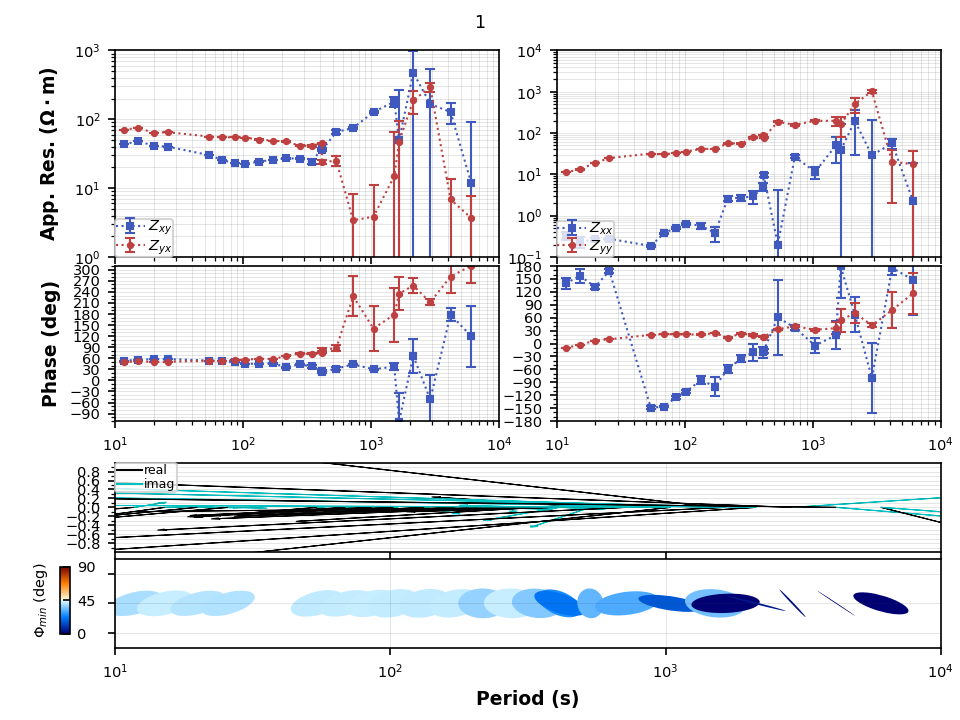

In [13]:
mt_obj = MT()
mt_obj.read(edi.fn)
p1 = mt_obj.plot_mt_response(fig_num=3, plot_num=2)